In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import optuna

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
# set visibility for all the columns
pd.set_option('display.max_columns', None)

In [3]:
# Load the datasets
df = pd.read_csv('Training_dataset.csv')
test_df = pd.read_csv('Test_dataset.csv')

In [ ]:
def missing_data_info(df):
    total_missing = df.isnull().sum()
    percent_missing = (df.isnull().sum() / df.shape[0]) * 100
    
    # Combine the results into a DataFrame and sort by the 'Percent' column
    missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Percent'] > 0].sort_values(by='Percent', ascending=False)
    
    return missing_data

In [ ]:
missing_data_info(test_df)

In [ ]:
imputation_features = ['VehColorExt','VehColorInt','VehDriveTrain','VehEngine','VehFeats','VehHistory','VehMileage',
                      'VehPriceLabel','VehSellerNotes','VehTransmission']

In [ ]:
test_df.shape

# Frame the problem
The problem is:
- Regression: predict the price at which car was listed by the dealer
- Classification: classify the value of the trim

We are dealing with:
- [Cadillac XT5](https://en.wikipedia.org/wiki/Cadillac_XT5) </br>
- [Jeep Grand Cherokee (WK2)](https://en.wikipedia.org/wiki/Jeep_Grand_Cherokee_%28WK2%29)

### Small Theory

#### Cadilac XT5
1. Trim levels ( 4 kinds)
- Base
- Luxury
- Premium Luxury
- Platinum

#### Jeep Cherokee
2. Trim levels (many)
- Laredo
- Laredo E
- Upland
- Laredo X
- Trail Hawk
- Limited
- Sterling Edition
- Overland
- Overland Summit/ Summit
- SRT
- Trackhawk

- Regression: RMSE
- Classification: AUC

# Data Exploration - train/ validation data

In [ ]:
df.shape

In [ ]:
df.head(2)

In [ ]:
df.set_index('ListingID', inplace=True)

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
duplicate_count = df[df.duplicated()].shape[0]
print(f"There are {duplicate_count} duplicate rows.")

# 1.Target variables
- show missing values
- delete missing values

In [ ]:
target_variables = ['Vehicle_Trim','Dealer_Listing_Price']

In [ ]:
missing_data_info(df)

In [ ]:
# dropping target NaN's as we cant do anything about them 
df = df.dropna(subset=['Vehicle_Trim', 'Dealer_Listing_Price'])

In [ ]:
y = df[target_variables]

In [ ]:
y.head(4)

In [ ]:
df.shape

# 2. EDA - target variables

### Target variables - `Vehicle_Trim`

In [ ]:
# Get unique trims for Jeep
jeep_trims = df[df['VehMake'] == 'Jeep']['Vehicle_Trim'].unique()
jeep_trims_df = pd.DataFrame({'Jeep Trims' : pd.Series(jeep_trims)})

# Get unique trims for Cadillac
cadillac_trims = df[df['VehMake'] == 'Cadillac']['Vehicle_Trim'].unique()
cadilac_trims_df = pd.DataFrame({'Jeep Trims' : pd.Series(cadillac_trims)})

def value_counts_info(df):
    all_data = []
    
    for column in df.columns:
        counts = df[column].value_counts()
        percent = (df[column].value_counts() / df.shape[0]) * 100
        
        data = pd.concat([counts, percent], axis=1, keys=['Counts', 'Percent']).reset_index()
        data.rename(columns={'index': 'Value'}, inplace=True)
        data['Column'] = column
        all_data.append(data)
        print('Total count: ',counts.sum())
        
    final_df = pd.concat(all_data, axis=0, ignore_index=True).pivot_table(index=['Column', 'Value'], values=['Counts', 'Percent'], aggfunc='first')
    final_df = final_df.sort_values(by='Percent', ascending=False)

    return final_df

### 2.1. Jeeps

#### Jeep Cherokee
1. Trim levels (many)
- Laredo
- Laredo E
- Upland
- Laredo X
- Trail Hawk
- Limited
- Sterling Edition
- Overland
- Overland Summit/ Summit
- SRT
- Trackhawk

In [ ]:
jeep_trims_df

In [ ]:
# Jeep
value_counts_info(pd.DataFrame(df[df['VehMake'] == 'Jeep']['Vehicle_Trim']))

In [ ]:
# Mapping dictionary
mapping = {
    'Limited 75th Anniversary Edition': 'Limited',
    'Limited X': 'Limited',
    'Limited 4x4': 'Limited',
    'Limited 75th Anniversary': 'Limited',

    'Laredo E': 'Laredo',

    'SRT Night': 'SRT',
    
    'Summit': 'Overland',

    'Trackhawk': 'Trailhawk',
    
    'High Altitude': 'Altitude'}

# Replace and groupby
df['Vehicle_Trim'] = df['Vehicle_Trim'].replace(mapping)
# dropping 
jeep_drop_trims = ['75th Anniversary Edition', 'Upland','75th Anniversary','Sterling Edition']

original_row_count = len(df)
df = df[~df['Vehicle_Trim'].isin(jeep_drop_trims)]

# Calculate the number of removed rows
removed_rows_count = original_row_count - len(df)
print(removed_rows_count)

In [ ]:
value_counts_info(pd.DataFrame(df[df['VehMake'] == 'Jeep']['Vehicle_Trim']))

In [ ]:
jeep_trims = df[df['VehMake'] == 'Jeep']['Vehicle_Trim'].value_counts()

# Plotting the bar chart
ax = jeep_trims.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.xlabel('Vehicle Trim')
plt.ylabel('Counts')
plt.title('Jeep Vehicle Trim Distribution')
plt.grid()
plt.xticks(rotation=45)

# Adding count annotations to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### 2.2. Cadillac

#### Cadillac XT5
1. Trim levels ( 4 kinds)
- Base
- Luxury
- Premium Luxury
- Platinum


In [ ]:
cadilac_trims_df

In [ ]:
# Cadilac
value_counts_info(pd.DataFrame(df[df['VehMake'] == 'Cadillac']['Vehicle_Trim']))

In [ ]:
# Mapping dictionary
mapping = {
    'Premium Luxury AWD': 'Premium',
    'Premium Luxury FWD': 'Premium',
    'Premium Luxury': 'Premium',
    
    'Luxury FWD': 'Luxury',
    'Luxury': 'Luxury',
    'Luxury AWD': 'Luxury',
    
    'Base': 'Base',
    'FWD': 'Base',
    
    'Platinum': 'Platinum',
    'Platinum AWD': 'Platinum'}

# Replace and groupby
df['Vehicle_Trim'] = df['Vehicle_Trim'].replace(mapping)

# dropping 
# cadillac_drop_trims = ['NaN']

# original_row_count = len(df)
# df = df[~df['Vehicle_Trim'].isin(cadillac_drop_trims)]

# # Calculate the number of removed rows
# removed_rows_count = original_row_count - len(df)
# print(removed_rows_count)

In [ ]:
value_counts_info(pd.DataFrame(df[df['VehMake'] == 'Cadillac']['Vehicle_Trim']))

In [ ]:
jeep_trims = df[df['VehMake'] == 'Cadillac']['Vehicle_Trim'].value_counts()

# Plotting the bar chart
ax = jeep_trims.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.xlabel('Vehicle Trim')
plt.ylabel('Counts')
plt.title('Cadillac Vehicle Trim Distribution')
plt.grid()
plt.xticks(rotation=45)

# Adding count annotations to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [ ]:
df.shape

In [ ]:
value_counts_info(pd.DataFrame(df[['Vehicle_Trim']]))

In [ ]:
df['Vehicle_Trim'].isnull().sum()

### Target Variable - `Dealer_Listing_Price`

In [ ]:
y.Dealer_Listing_Price.describe()

In [ ]:
cad_price = df[df['VehMake'] == 'Cadillac']['Dealer_Listing_Price']
jeep_price = df[df['VehMake'] == 'Jeep']['Dealer_Listing_Price']

In [ ]:
plt.figure()
sns.histplot(cad_price, label='Cadillac', alpha=0.6)
sns.histplot(jeep_price, label='Jeep',alpha=0.6)
plt.legend()
plt.grid()
plt.show()

# 3. EDA - features

In [ ]:
target_variables

In [ ]:
df.shape

In [ ]:
df.head(2)

In [ ]:
x = df.copy()#.drop(columns=target_variables)

In [ ]:
missing_data_info(x)

In [ ]:
x = x.dropna()
print(x.shape)

In [ ]:
missing_data_info(x)

In [ ]:
x.info()

In [ ]:
X_LEN = len(x)

In [ ]:
numerical_features = []
categorical_features = []

In [ ]:
def feature_analyzer(feature: str):
    if x[feature].dtype == 'O':
        print('Categorical feature')
        print('Number of Unique values:',len(x[feature].unique()))
        print(f'Missing values {x[feature].isnull().sum()}, % missing values {np.round(x[feature].isnull().sum()/X_LEN*100, 2)}')
        print()
        print('Unique Values:')
        print(x[feature].unique())
        
    elif x[feature].dtype == 'bool':
            print('Boolean feature')
            print(f'Missing values {x[feature].isnull().sum()}, % missing values {np.round(x[feature].isnull().sum()/X_LEN*100, 2)}')
            print(f"False count {len(x[feature])-x[feature].sum()}, True count {x[feature].sum()}")
    else:
        print('Numerical Feature')
        plt.figure()
        plt.title(feature)
        sns.histplot(x[feature], label=feature)
        plt.legend()
        plt.grid()
        plt.show()
        
        
def single_value_counts_info(feature):
    
    df = pd.DataFrame(x[feature])
    all_data = []
    
    for column in df.columns:
        counts = df[column].value_counts()
        percent = (df[column].value_counts() / df.shape[0]) * 100
        
        data = pd.concat([counts, percent], axis=1, keys=['Counts', 'Percent']).reset_index()
        data.rename(columns={'index': 'Value'}, inplace=True)
        data['Column'] = column
        all_data.append(data)
        print('Total count: ',counts.sum())
        
    final_df = pd.concat(all_data, axis=0, ignore_index=True).pivot_table(index=['Column', 'Value'], values=['Counts', 'Percent'], aggfunc='first')
    final_df = final_df.sort_values(by='Percent', ascending=False)

    return final_df

#### Going through each and every feature

1. `SellerCity`
- DROP: too many values 

In [ ]:
feature_analyzer('SellerCity')

2. `SellerIsPriv`
- DROP: has only one value

In [ ]:
feature_analyzer('SellerIsPriv')

3. SellerListSrc
- Added to categorical: one hot encoding

In [ ]:
feature_analyzer('SellerListSrc')

In [ ]:
single_value_counts_info('SellerListSrc')

In [ ]:
categorical_features.append('SellerListSrc')

4. SellerName
- DROP

In [ ]:
feature_analyzer('SellerName')

5. SellerRating
- added to numerical

In [ ]:
feature_analyzer('SellerRating')

In [ ]:
numerical_features.append('SellerRating')

6. SellerRevCnt
- use log transform and add that as numerical

In [ ]:
feature_analyzer('SellerRevCnt')

In [ ]:
x['SellerRevCnt_log'] = np.log1p(x['SellerRevCnt']+1)

In [ ]:
feature_analyzer('SellerRevCnt_log')

In [ ]:
numerical_features.append('SellerRevCnt')

7. SellerState
- one hot

In [ ]:
feature_analyzer('SellerState')

In [ ]:
single_value_counts_info('SellerState')

In [ ]:
categorical_features.append('SellerState')

8. SellerZip
- drop, we already have the state 

In [ ]:
feature_analyzer('SellerZip')

9. VehBodystyle
- DROP: has one value only

In [ ]:
feature_analyzer('VehBodystyle')

 10. VehCertified
 - bool added 


In [ ]:
feature_analyzer('VehCertified')

In [ ]:
categorical_features.append('VehCertified')

 10. VehColorExt
 - categorical added, but extracted colors

In [ ]:
feature_analyzer('VehColorExt')

In [ ]:
def basic_color(color):
    base_colors = ['Black', 'White', 'Red', 'Silver', 'Blue', 'Gray', 'Brown', 'Gold' ]
    for base in base_colors:
        if base.lower() in color.lower():
            return base
    return 'Other'

x['BasicExtColor'] = x['VehColorExt'].apply(basic_color)

In [ ]:
single_value_counts_info('BasicExtColor')

In [ ]:
categorical_features.append('VehColorExt')

 11. VehColorInt
 - changed to boolean whether has leather or not


In [ ]:
feature_analyzer('VehColorInt')

In [ ]:
x['ContainsLeather'] = x['VehColorInt'].str.contains('leather', case=False).astype(bool)

In [ ]:
feature_analyzer('ContainsLeather')

In [ ]:
categorical_features.append('VehColorInt')

 12. VehDriveTrain


In [ ]:
feature_analyzer('VehDriveTrain')

In [ ]:
drivetrain_mapping = {
    '4x4/4WD': 'all_drive',
    '4WD': 'all_drive',
    'FWD': 'front_drive',
    'AWD': 'all_drive',
    '4x4': 'all_drive',
    'Four Wheel Drive': 'all_drive',
    '4X4': 'all_drive',
    'All Wheel Drive': 'all_drive',
    'ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL': 'all_drive',
    'AWD or 4x4': 'all_drive',
    'Front Wheel Drive': 'all_drive',
    'All-wheel Drive': 'all_drive',
    'ALL WHEEL': 'all_drive',
    'AllWheelDrive': 'all_drive',
    '4WD/AWD': 'all_drive'
}

x['Drivetrain'] = x['VehDriveTrain'].replace(drivetrain_mapping).astype('O')

In [ ]:
feature_analyzer('Drivetrain')

In [ ]:
single_value_counts_info('Drivetrain')

In [ ]:
categorical_features.append('VehDriveTrain')

 13. VehEngine


In [ ]:
feature_analyzer('VehEngine')

In [ ]:
import re
x['Displacement'] = x['VehEngine'].apply(lambda x: float(re.search(r'(\d+\.\d+)', x).group(1)) if re.search(r'(\d+\.\d+)', x) else 0)

engine_types = ['turbo', 'supercharged', 'diesel', 'hemi']

def categorize_engine(engine):
    for etype in engine_types:
        if etype in engine.lower():
            return etype.capitalize()
    return 'Other'

# Apply function to the 'VehEngine' column
x['Engine_Category'] = x['VehEngine'].apply(categorize_engine)

In [ ]:
feature_analyzer('Engine_Category')

In [ ]:
single_value_counts_info('Engine_Category')

In [ ]:
categorical_features.append('VehEngine')

 14. VehFeats
 - too many features, so will combine them and return count of features


In [ ]:
feature_analyzer('VehFeats')

In [ ]:
x['VehFeatsCount'] = x['VehFeats'].apply(lambda x: len(x.split(',')))

In [ ]:
x['VehFeatsCount'].isnull().sum()

In [ ]:
feature_analyzer('VehFeatsCount')

In [ ]:
single_value_counts_info('VehFeatsCount')

In [ ]:
categorical_features.append('VehFeats')

15. VehFuel

In [ ]:
feature_analyzer('VehFuel')

In [ ]:
single_value_counts_info('VehFuel')

In [ ]:
categorical_features.append('VehFuel')

16. VehHistory 

In [ ]:
feature_analyzer('VehHistory')

In [ ]:
unique_labels = set()

for entry in x.VehHistory.unique():
    # Split by comma and strip each substring to remove leading/trailing spaces
    labels = [label.strip() for label in entry.split(',')]
    unique_labels.update(labels)

# Convert set back to a list
unique_labels_list = list(unique_labels)
print(unique_labels_list)

1. Extract the number of owners.
2. Create a binary feature to indicate if accidents were reported.
3. Create a binary feature to indicate if the vehicle had non-personal use.
4. Create a binary feature to indicate if there's a title issue.
5. Create a binary feature to indicate if there's buyback protection eligibility.

In [ ]:
# Extract number of owners and create a new column
x['Num_Owners'] = x['VehHistory'].str.extract(r'(\d+) Owner').astype(int)

# Check if accidents were reported
x['AccidentReported'] = x['VehHistory'].str.contains(r'Accident\(s\) Reported').astype(bool)

# Check if non-personal use was reported
x['NonPersonalUse'] = x['VehHistory'].str.contains('Non-Personal Use Reported').astype(bool)

# Check for title issues
x['TitleIssues'] = x['VehHistory'].str.contains(r'Title Issue\(s\) Reported').astype(bool)

# Check for buyback protection eligibility
x['BuybackProtection'] = x['VehHistory'].str.contains('Buyback Protection Eligible').astype(bool)


In [ ]:
feature_analyzer('BuybackProtection')

In [ ]:
single_value_counts_info('Num_Owners')


In [ ]:
single_value_counts_info('AccidentReported')


In [ ]:
categorical_features.append('VehHistory')

17. VehListdays

In [ ]:
feature_analyzer('VehListdays')

In [ ]:
x['VehListdays_log'] = np.log1p(x['VehListdays']+1)

In [ ]:
feature_analyzer('VehListdays_log')

In [ ]:
numerical_features.append('VehListdays')

18. VehMake 

In [ ]:
feature_analyzer('VehMake')

In [ ]:
single_value_counts_info('VehMake')

In [ ]:
categorical_features.append('VehMake')

19. VehMileage 


In [ ]:
feature_analyzer('VehMileage')

In [ ]:
numerical_features.append('VehMileage')

20. VehModel
- DROP: they are repetitive to `VehMake`

In [ ]:
feature_analyzer('VehModel')

 21. VehPriceLabel
 - DROP!: potential data leakage

In [ ]:
feature_analyzer('VehPriceLabel')

In [ ]:
single_value_counts_info('VehPriceLabel')

Wen need to be aware of potential **data leakage**, especially if: </br>
`VehPriceLabel` is determined using the `Dealer_Listing_Price`. In that scenario, using both could lead to over-optimistic estimates of model performance. You would need to know the exact mechanism by which VehPriceLabel is determined. If it's purely based on Dealer_Listing_Price, you might consider excluding it from the features when predicting the price to avoid this leakage.

22.  VehSellerNotes
- NLP needed!


In [ ]:
feature_analyzer('VehSellerNotes')

 23. VehType
- DROP: no new information

In [ ]:
feature_analyzer('VehType')

24.  VehTransmission 
- DROP

In [ ]:
feature_analyzer('VehTransmission')

25.  VehYear   


In [ ]:
CURRENT_YEAR = 2023
# the older the car the cheaper it can be
x['VehAge'] = CURRENT_YEAR - x['VehYear']

In [ ]:
feature_analyzer('VehAge')

In [ ]:
numerical_features.append('VehYear')

# Create a function for processing features
- will be used for the test as well

In [91]:
# Load the datasets
df = pd.read_csv('Training_dataset.csv')
test_df = pd.read_csv('Test_dataset.csv')

In [60]:
def preprocessing(df):
    
    CURRENT_YEAR = 2023

    def one_hot_fn(dataframe: pd.DataFrame, feature_name: str):
        # One-hot encode the 'feature' column
        encoded_columns = pd.get_dummies(dataframe[feature_name], prefix=feature_name)
        # Drop the original 'feature' column
        dataframe.drop(feature_name, axis=1, inplace=True)
        # Concatenate the original DataFrame and the one-hot encoded columns
        dataframe = pd.concat([dataframe, encoded_columns], axis=1)
        return dataframe
    
    # DONE
    def veh_drive_train_transform(df):
        drivetrain_mapping = {
        '4x4/4WD': 'all_drive',
        '4WD': 'all_drive',
        'FWD': 'front_drive',
        'AWD': 'all_drive',
        '4x4': 'all_drive',
        'Four Wheel Drive': 'all_drive',
        '4X4': 'all_drive',
        'All Wheel Drive': 'all_drive',
        'ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL': 'all_drive',
        'AWD or 4x4': 'all_drive',
        'Front Wheel Drive': 'all_drive',
        'All-wheel Drive': 'all_drive',
        'ALL WHEEL': 'all_drive',
        'AllWheelDrive': 'all_drive',
        '4WD/AWD': 'all_drive'}

        df['VehDrive'] = df['VehDriveTrain'].replace(drivetrain_mapping)
        # Determine the most frequent value after mapping
        most_frequent = df['VehDrive'].mode()[0]
        # Replace NaN values with the most frequent value
        df['VehDrive'].fillna(most_frequent, inplace=True)
        
        # Handle unknown categories
        known_values = set(drivetrain_mapping.values())
        df.loc[~df['VehDrive'].isin(known_values), 'VehDrive'] = 'other'
        
        # one hot encode
        df = one_hot_fn(df, 'VehDrive')
        df.drop('VehDriveTrain', axis=1, inplace=True)
        return df
    
    # DONE
    def veh_feats_transform(df):
        # Perform mapping to count the features per vehicle
        df['VehFeatsCount'] = df['VehFeats'].apply(lambda x: len(str(x).split(',')) if not pd.isna(x) else None)
        # Determine the most frequent count value
        most_frequent = df['VehFeatsCount'].mode()[0]
        # Use the most frequent value for imputation of NaN values
        df['VehFeatsCount'].fillna(most_frequent, inplace=True)
        # Drop the original 'VehFeats' column
        df.drop('VehFeats', axis=1, inplace=True)

        return df

    # DONE
    def veh_color_ext_transform(df):
        # NaNs will be filled with color White! - most popular color
        def basic_color(color):
            if pd.isna(color):
                return 'White'
            elif not isinstance(color, str):
                return 'Other'

            base_colors = ['Black', 'White', 'Red', 'Silver', 'Blue', 'Gray', 'Brown', 'Gold']
            for base in base_colors:
                if base.lower() in color.lower():
                    return base
            return 'Other'

        df['BasicExtColor'] = df['VehColorExt'].apply(basic_color)
        df.drop('VehColorExt', axis=1, inplace=True)
        df = one_hot_fn(df, 'BasicExtColor')
        
        return df
    
    # DONE!
    def veh_color_int_transform(df):
        # Nans -> False/ 0 (because non-leather cars are more popular)
        df['ContainsLeather'] = df['VehColorInt'].str.contains('leather', case=False, na=False).astype(bool)
        df.drop('VehColorInt', axis=1, inplace=True)
        df['ContainsLeather'] = df['ContainsLeather'].astype(int)
        return df
    
    # DONE
    def veh_engine_transform(df):
        def get_displacement(engine):
            if pd.isna(engine) or not isinstance(engine, str):
                return 0
            match = re.search(r'(\d+\.\d+)', engine)
            return float(match.group(1)) if match else 0

        df['Displacement'] = df['VehEngine'].apply(get_displacement)

        engine_types = ['turbo', 'supercharged', 'diesel', 'hemi']

        def categorize_engine(engine):
            if pd.isna(engine) or not isinstance(engine, str):
                return 'Other'
            for etype in engine_types:
                if etype in engine.lower():
                    return etype.capitalize()
            return 'Other'

        df['Engine_Category'] = df['VehEngine'].apply(categorize_engine)
        df.drop('VehEngine', axis=1, inplace=True)

        # Assuming one_hot_fn is a function that takes in a dataframe and a column name to one-hot encode.
        df = one_hot_fn(df, 'Engine_Category')
        return df
    
    #DONE
    def veh_history_transform(df):
        # Extract number of owners and create a new column
        df['Num_Owners'] = df['VehHistory'].str.extract(r'(\d+) Owner')

        # Check if accidents were reported
        df['AccidentReported'] = df['VehHistory'].str.contains(r'Accident\(s\) Reported')

        # Check if non-personal use was reported
        df['NonPersonalUse'] = df['VehHistory'].str.contains('Non-Personal Use Reported')

        # Check for title issues
        df['TitleIssues'] = df['VehHistory'].str.contains(r'Title Issue\(s\) Reported')

        # Check for buyback protection eligibility
        df['BuybackProtection'] = df['VehHistory'].str.contains('Buyback Protection Eligible')

        # Impute NaNs for each new feature using the most frequent value of that feature
        new_features = ['Num_Owners', 'AccidentReported', 'NonPersonalUse', 'TitleIssues', 'BuybackProtection']
        for feature in new_features:
            most_common = df[feature].mode()[0]
            df[feature].fillna(most_common, inplace=True)

        # Convert boolean and object columns to integers
        df['Num_Owners'] = df['Num_Owners'].astype(int)
        df['AccidentReported'] = df['AccidentReported'].astype(int)
        df['NonPersonalUse'] = df['NonPersonalUse'].astype(int)
        df['TitleIssues'] = df['TitleIssues'].astype(int)
        df['BuybackProtection'] = df['BuybackProtection'].astype(int)

        # Drop the original 'VehHistory' column
        df.drop('VehHistory', axis=1, inplace=True)
        return df
    
    # DONE
    def veh_make_transform(df):
        vehmake_mapping = {
        "Jeep": 1,
        "Cadillac": 0}

        df['Is_Jeep'] = df['VehMake'].map(vehmake_mapping)
        df.drop('VehMake', axis=1, inplace=True)
        return df
    
    # DONE
    def veh_mileage_transform(df):
        # Calculate the mean of the 'VehMileage' column
        mileage_mean = df['VehMileage'].mean()
        # Impute NaN values in the 'VehMileage' column with the computed mean
        df['VehMileage'].fillna(mileage_mean, inplace=True)
        return df

    df.set_index('ListingID', inplace=True)

    # dropping unused features
    unused_features = ['VehTransmission','VehBodystyle','SellerZip','VehType','VehSellerNotes',
                       'VehPriceLabel','VehModel','SellerIsPriv','SellerName','SellerCity']
    
    df = df.drop(unused_features, axis=1)
    
    # features requiring one-hot-encoding
    df = one_hot_fn(df, 'SellerListSrc')
    df = one_hot_fn(df, 'VehFuel')
    df = one_hot_fn(df, 'SellerState')

    # features requiring log transform
    df['SellerRevCnt'] = np.log1p(df['SellerRevCnt'])
    df['VehListdays'] = np.log1p(df['VehListdays'])

    # new feature
    df['VehAge'] = CURRENT_YEAR - df['VehYear']
    df.drop('VehYear', axis=1, inplace=True)
    
    # boolean encoding
    df['VehCertified'] = df['VehCertified'].astype(int)
    
    # new feature
    df = veh_drive_train_transform(df)
    df = veh_feats_transform(df)
    df = veh_color_ext_transform(df)
    df = veh_color_int_transform(df)
    df = veh_engine_transform(df)
    df = veh_history_transform(df)
    df = veh_make_transform(df)
    df = veh_mileage_transform(df)
    
    # drop any remaining nans
    df = df.dropna()

    
    # deal with badly parsed column names
    df.columns = [col.replace(' ', '_') for col in df.columns]
    

    return df


def preprocessing_target_features(df):
    
    df = df.dropna(subset=['Vehicle_Trim', 'Dealer_Listing_Price'])

    # Mapping dictionary
    jeep_mapping = {
        'Limited 75th Anniversary Edition': 'Limited',
        'Limited X': 'Limited',
        'Limited 4x4': 'Limited',
        'Limited 75th Anniversary': 'Limited',

        'Laredo E': 'Laredo',

        'SRT Night': 'SRT',

        'Summit': 'Overland',

        'Trackhawk': 'Trailhawk',

        'High Altitude': 'Altitude'}

    # Replace and groupby
    df['Vehicle_Trim'] = df['Vehicle_Trim'].replace(jeep_mapping)
    # dropping 
    jeep_drop_trims = ['75th Anniversary Edition', 'Upland','75th Anniversary','Sterling Edition']

    df = df[~df['Vehicle_Trim'].isin(jeep_drop_trims)]

    # Mapping dictionary
    cadillac_mapping = {
        'Premium Luxury AWD': 'Premium',
        'Premium Luxury FWD': 'Premium',
        'Premium Luxury': 'Premium',

        'Luxury FWD': 'Luxury',
        'Luxury': 'Luxury',
        'Luxury AWD': 'Luxury',

        'Base': 'Base',
        'FWD': 'Base',

        'Platinum': 'Platinum',
        'Platinum AWD': 'Platinum'}

    # Replace and groupby
    df['Vehicle_Trim'] = df['Vehicle_Trim'].replace(cadillac_mapping)
    
    return df

In [83]:
df.columns

Index(['ListingID', 'SellerCity', 'SellerIsPriv', 'SellerListSrc',
       'SellerName', 'SellerRating', 'SellerRevCnt', 'SellerState',
       'SellerZip', 'VehBodystyle', 'VehCertified', 'VehColorExt',
       'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFeats', 'VehFuel',
       'VehHistory', 'VehListdays', 'VehMake', 'VehMileage', 'VehModel',
       'VehPriceLabel', 'VehSellerNotes', 'VehType', 'VehTransmission',
       'VehYear', 'Vehicle_Trim', 'Dealer_Listing_Price'],
      dtype='object')

In [84]:
df.shape

(6298, 29)

In [85]:
df.columns

Index(['ListingID', 'SellerCity', 'SellerIsPriv', 'SellerListSrc',
       'SellerName', 'SellerRating', 'SellerRevCnt', 'SellerState',
       'SellerZip', 'VehBodystyle', 'VehCertified', 'VehColorExt',
       'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFeats', 'VehFuel',
       'VehHistory', 'VehListdays', 'VehMake', 'VehMileage', 'VehModel',
       'VehPriceLabel', 'VehSellerNotes', 'VehType', 'VehTransmission',
       'VehYear', 'Vehicle_Trim', 'Dealer_Listing_Price'],
      dtype='object')

In [86]:
preprocessed_df = preprocessing(df)
df_final = preprocessing_target_features(preprocessed_df)

In [87]:
null_columns = df_final.columns[df_final.isnull().sum() > 0]
print(null_columns)

Index([], dtype='object')


In [88]:
df_final.Is_Jeep.value_counts()

1    3990
0    1811
Name: Is_Jeep, dtype: int64

Test set checking

In [89]:
def align_datasets(train, test):
    """Align train and test dataframes to have the same columns."""
    # Keep only columns present in both dataframes and fill missing values
    train, test = train.align(test, join='left', axis=1)
    test = test.fillna(0)  # Assuming you want to fill missing values in test with 0
    return train, test

In [92]:
df_train_final = preprocessing(df)
df_test_final = preprocessing(test_df)

In [93]:
print('Train shape',df_train_final.shape)
print('Test shape',df_test_final.shape)

Train shape (5839, 96)
Test shape (1000, 84)


In [96]:
df_test_final.columns

Index(['SellerRating', 'SellerRevCnt', 'VehCertified', 'VehListdays',
       'VehMileage', 'SellerListSrc_Cadillac_Certified_Program',
       'SellerListSrc_Digital_Motorworks_(DMi)',
       'SellerListSrc_HomeNet_Automotive',
       'SellerListSrc_Inventory_Command_Center',
       'SellerListSrc_Jeep_Certified_Program',
       'SellerListSrc_My_Dealer_Center', 'SellerListSrc_Sell_It_Yourself',
       'VehFuel_Diesel', 'VehFuel_E85_Flex_Fuel', 'VehFuel_Gasoline',
       'SellerState_AK', 'SellerState_AL', 'SellerState_AR', 'SellerState_AZ',
       'SellerState_CA', 'SellerState_CO', 'SellerState_CT', 'SellerState_DE',
       'SellerState_FL', 'SellerState_GA', 'SellerState_IA', 'SellerState_ID',
       'SellerState_IL', 'SellerState_IN', 'SellerState_KS', 'SellerState_KY',
       'SellerState_LA', 'SellerState_MA', 'SellerState_MD', 'SellerState_MI',
       'SellerState_MN', 'SellerState_MO', 'SellerState_MS', 'SellerState_NC',
       'SellerState_ND', 'SellerState_NE', 'SellerState_NH

In [94]:
train_align, test_align = align_datasets(df_train_final, df_test_final)

In [95]:
print('Train align shape',train_align.shape)
print('Test align shape',test_align.shape)

Train align shape (5839, 96)
Test align shape (1000, 96)


In [97]:
test_align.columns

Index(['SellerRating', 'SellerRevCnt', 'VehCertified', 'VehListdays',
       'VehMileage', 'Vehicle_Trim', 'Dealer_Listing_Price',
       'SellerListSrc_Cadillac_Certified_Program',
       'SellerListSrc_Digital_Motorworks_(DMi)',
       'SellerListSrc_Five_Star_Certified_Program',
       'SellerListSrc_HomeNet_Automotive',
       'SellerListSrc_Inventory_Command_Center',
       'SellerListSrc_Jeep_Certified_Program',
       'SellerListSrc_My_Dealer_Center', 'SellerListSrc_Sell_It_Yourself',
       'VehFuel_Diesel', 'VehFuel_E85_Flex_Fuel', 'VehFuel_Gasoline',
       'VehFuel_Unknown', 'SellerState_AK', 'SellerState_AL', 'SellerState_AR',
       'SellerState_AZ', 'SellerState_CA', 'SellerState_CO', 'SellerState_CT',
       'SellerState_DE', 'SellerState_FL', 'SellerState_GA', 'SellerState_HI',
       'SellerState_IA', 'SellerState_ID', 'SellerState_IL', 'SellerState_IN',
       'SellerState_KS', 'SellerState_KY', 'SellerState_LA', 'SellerState_MA',
       'SellerState_MD', 'SellerState

### Feature Selection

To do!

### ML Vehicle Trim

In [28]:
# Label Encoding
le = LabelEncoder()
df_final['Vehicle_Trim'] = le.fit_transform(df_final['Vehicle_Trim'])

In [29]:
# Splitting data into training and test sets
X = df_final.drop(['Vehicle_Trim', 'Dealer_Listing_Price'], axis=1)
y = df_final['Vehicle_Trim']

In [30]:
# K-Fold Cross Validation
FOLDS=5
fold_num = 1
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)


roc_auc_scores = []
y_valid_probs = []

for train_index, valid_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    

    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='merror')
    model.fit(X_train, y_train) 
    
    # Predictions
    y_valid_prob  = model.predict_proba(X_valid)
    y_valid_probs.append(y_valid_prob)
    
    # Evaluate the model for current fold
    roc_auc = roc_auc_score(y_valid, y_valid_prob, multi_class='ovr')
    roc_auc_scores.append(roc_auc)
    
    print(f"Fold {fold_num} ROC AUC Score: {roc_auc}")
    fold_num += 1
    
print()
print(f"The average ROC AUC Score: {np.mean(roc_auc_scores)}")

Fold 1 ROC AUC Score: 0.9433505239926359
Fold 2 ROC AUC Score: 0.9346908642852444
Fold 3 ROC AUC Score: 0.9356851736598456
Fold 4 ROC AUC Score: 0.9394546051080411
Fold 5 ROC AUC Score: 0.934444610895188

The average ROC AUC Score: 0.9375251555881909


The `roc_auc_score` is typically used for binary classification problems. When dealing with multiclass classification, we can compute a ROC AUC score by treating each class as binary (one-vs-all) and then averaging over all classes.

We have two options: 
1. `ovo (one-vs-one)`: For n classes it trains n(n-1)/2 binary classifiers. 
2. `ovr (one-vs-rest)` For n classes, it trains n binary classifiers. For each classifier, one class is treated as positive while all others are negative.


#### Training model

ROC Score:  0.9433505239926359
              precision    recall  f1-score   support

           0       0.51      0.33      0.40        80
           1       0.67      0.42      0.51        43
           2       0.59      0.47      0.53       139
           3       0.68      0.86      0.76       383
           4       0.57      0.75      0.65       133
           5       0.64      0.50      0.56       122
           6       0.70      0.61      0.66        31
           7       0.80      0.70      0.74       171
           8       1.00      1.00      1.00        18
           9       0.48      0.27      0.34        41

    accuracy                           0.66      1161
   macro avg       0.66      0.59      0.62      1161
weighted avg       0.66      0.66      0.65      1161



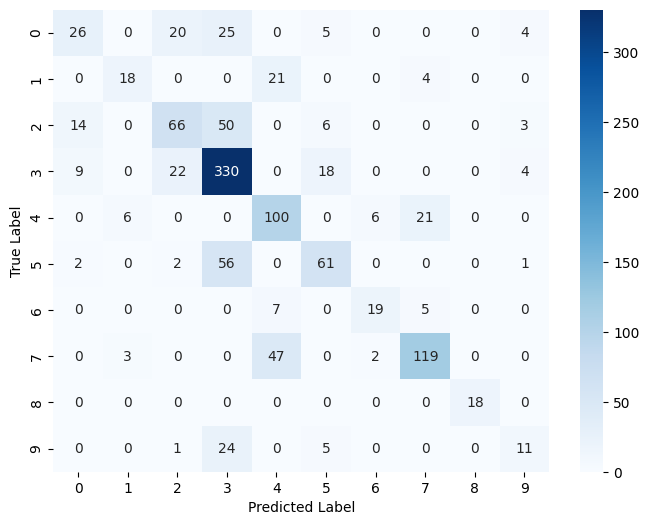

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='merror')
model.fit(X_train, y_train) 

# Predictions
y_valid_prob  = model.predict_proba(X_valid)
y_valid_label = np.argmax(y_valid_prob, axis=1)

roc_auc = roc_auc_score(y_valid, y_valid_prob, multi_class='ovr')

print('ROC Score: ',roc_auc)

report = classification_report(y_valid, y_valid_label)
print(report)

cm = confusion_matrix(y_valid, y_valid_label)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Hyperparameter tunning using optuna

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
def objective(trial):
    # Define hyperparameter search space
    print('Trial: ', trial.number)

        
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'use_label_encoder': False,
        'eval_metric': 'merror'
    }

    # Initialize and train classifier
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    # Predictions
    y_valid_prob = model.predict_proba(X_valid)

    # Return AUC
    return roc_auc_score(y_valid, y_valid_prob, multi_class='ovr')

ROC

In [39]:
# def objective(trial):
#     # Define hyperparameter search space
    
#     print('Trial: ', trial.number)
    
#     param = {
#         'objective': 'multi:softprob',  # Set objective to multi:softprob for multiclass classification
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 9),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
#         'gamma': trial.suggest_float('gamma', 0, 0.5),
#         'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'num_class': len(np.unique(y_train)),  # Assuming y_train is globally available
#         'use_label_encoder': False,
#         'eval_metric': 'mlogloss'  # Multi-class log loss
#     }

#     # Initialize and train classifier
#     model = xgb.XGBClassifier(**param)
#     model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

#     # Predictions
#     y_test_prob = model.predict_proba(X_test)

#     # Return AUC
#     return roc_auc_score(y_test, y_test_prob, multi_class='ovr')

In [40]:
# Initiate the optimizer
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# Results
print(f"Number of finished trials: {len(study.trials)}\n")
print(f"Best trial parameters: {study.best_trial.params}\n")
print(f"Best AUC: {study.best_value}")

[I 2023-10-22 15:29:13,566] A new study created in memory with name: no-name-535d479c-4653-491e-b6d1-ef5747be7174


Trial:  0


[I 2023-10-22 15:29:20,573] Trial 0 finished with value: 0.9390895848732006 and parameters: {'n_estimators': 459, 'max_depth': 3, 'learning_rate': 0.041075528299448785, 'subsample': 0.8833304253311647, 'colsample_bytree': 0.7277794689746316, 'gamma': 0.1858916721282704, 'lambda': 8.515097959747286e-08, 'alpha': 1.809940578851941e-07, 'min_child_weight': 4}. Best is trial 0 with value: 0.9390895848732006.


Trial:  1


[I 2023-10-22 15:29:36,015] Trial 1 finished with value: 0.9345597751496101 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.08734558718984821, 'subsample': 0.538296817569771, 'colsample_bytree': 0.685094753361567, 'gamma': 0.421172133326688, 'lambda': 6.545992845645004e-05, 'alpha': 5.687288802456769e-07, 'min_child_weight': 10}. Best is trial 0 with value: 0.9390895848732006.


Number of finished trials: 2

Best trial parameters: {'n_estimators': 459, 'max_depth': 3, 'learning_rate': 0.041075528299448785, 'subsample': 0.8833304253311647, 'colsample_bytree': 0.7277794689746316, 'gamma': 0.1858916721282704, 'lambda': 8.515097959747286e-08, 'alpha': 1.809940578851941e-07, 'min_child_weight': 4}

Best AUC: 0.9390895848732006


### Final/ Best Model - train on full dataset

In [41]:
best_params = study.best_params
print(best_params)

{'n_estimators': 459, 'max_depth': 3, 'learning_rate': 0.041075528299448785, 'subsample': 0.8833304253311647, 'colsample_bytree': 0.7277794689746316, 'gamma': 0.1858916721282704, 'lambda': 8.515097959747286e-08, 'alpha': 1.809940578851941e-07, 'min_child_weight': 4}


In [42]:
# Add fixed parameters
best_params['use_label_encoder'] = False
best_params['eval_metric'] = 'merror'
best_params['num_class'] = len(np.unique(y))

# Train the model using the best parameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X, y)  # Here, I'm training on the entire dataset X, y.

XGBClassifier(alpha=1.809940578851941e-07, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7277794689746316, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', feature_types=None,
              gamma=0.1858916721282704, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=8.515097959747286e-08,
              learning_rate=0.041075528299448785, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=459, n_jobs=None, ...)

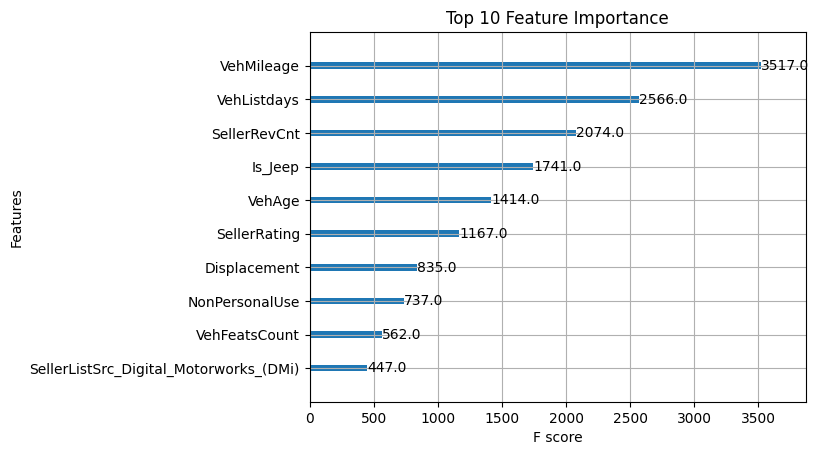

In [43]:
xgb.plot_importance(final_model, max_num_features=10)
plt.title('Top 10 Feature Importance')
plt.show()

In [55]:
test_df.columns

Index(['SellerCity', 'SellerIsPriv', 'SellerListSrc', 'SellerName',
       'SellerRating', 'SellerRevCnt', 'SellerState', 'SellerZip',
       'VehBodystyle', 'VehCertified', 'VehColorExt', 'VehColorInt',
       'VehDriveTrain', 'VehEngine', 'VehFeats', 'VehFuel', 'VehHistory',
       'VehListdays', 'VehMake', 'VehMileage', 'VehModel', 'VehPriceLabel',
       'VehSellerNotes', 'VehType', 'VehTransmission', 'VehYear'],
      dtype='object')

In [57]:
len(test_df.SellerState.value_counts())

44

In [58]:
len(df.SellerState.value_counts())

50

In [49]:
X_test = preprocessing(test_df)

In [50]:
X_test.columns[X_test.isnull().sum()>0]

Index([], dtype='object')

In [54]:
X_test.columns

Index(['SellerRating', 'SellerRevCnt', 'VehCertified', 'VehListdays',
       'VehMileage', 'SellerListSrc_Cadillac_Certified_Program',
       'SellerListSrc_Digital_Motorworks_(DMi)',
       'SellerListSrc_HomeNet_Automotive',
       'SellerListSrc_Inventory_Command_Center',
       'SellerListSrc_Jeep_Certified_Program',
       'SellerListSrc_My_Dealer_Center', 'SellerListSrc_Sell_It_Yourself',
       'VehFuel_Diesel', 'VehFuel_E85_Flex_Fuel', 'VehFuel_Gasoline',
       'SellerState_AK', 'SellerState_AL', 'SellerState_AR', 'SellerState_AZ',
       'SellerState_CA', 'SellerState_CO', 'SellerState_CT', 'SellerState_DE',
       'SellerState_FL', 'SellerState_GA', 'SellerState_IA', 'SellerState_ID',
       'SellerState_IL', 'SellerState_IN', 'SellerState_KS', 'SellerState_KY',
       'SellerState_LA', 'SellerState_MA', 'SellerState_MD', 'SellerState_MI',
       'SellerState_MN', 'SellerState_MO', 'SellerState_MS', 'SellerState_NC',
       'SellerState_ND', 'SellerState_NE', 'SellerState_NH

In [53]:
y_test_prob  = final_model.predict_proba(X_test)
y_pred_label = np.argmax(y_test_prob, axis=1)

ValueError: feature_names mismatch: ['SellerRating', 'SellerRevCnt', 'VehCertified', 'VehListdays', 'VehMileage', 'SellerListSrc_Cadillac_Certified_Program', 'SellerListSrc_Digital_Motorworks_(DMi)', 'SellerListSrc_Five_Star_Certified_Program', 'SellerListSrc_HomeNet_Automotive', 'SellerListSrc_Inventory_Command_Center', 'SellerListSrc_Jeep_Certified_Program', 'SellerListSrc_My_Dealer_Center', 'SellerListSrc_Sell_It_Yourself', 'VehFuel_Diesel', 'VehFuel_E85_Flex_Fuel', 'VehFuel_Gasoline', 'VehFuel_Unknown', 'SellerState_AK', 'SellerState_AL', 'SellerState_AR', 'SellerState_AZ', 'SellerState_CA', 'SellerState_CO', 'SellerState_CT', 'SellerState_DE', 'SellerState_FL', 'SellerState_GA', 'SellerState_HI', 'SellerState_IA', 'SellerState_ID', 'SellerState_IL', 'SellerState_IN', 'SellerState_KS', 'SellerState_KY', 'SellerState_LA', 'SellerState_MA', 'SellerState_MD', 'SellerState_ME', 'SellerState_MI', 'SellerState_MN', 'SellerState_MO', 'SellerState_MS', 'SellerState_MT', 'SellerState_NC', 'SellerState_ND', 'SellerState_NE', 'SellerState_NH', 'SellerState_NJ', 'SellerState_NM', 'SellerState_NV', 'SellerState_NY', 'SellerState_OH', 'SellerState_OK', 'SellerState_OR', 'SellerState_PA', 'SellerState_RI', 'SellerState_SC', 'SellerState_SD', 'SellerState_TN', 'SellerState_TX', 'SellerState_UT', 'SellerState_VA', 'SellerState_VT', 'SellerState_WA', 'SellerState_WI', 'SellerState_WV', 'SellerState_WY', 'VehAge', 'VehDrive_all_drive', 'VehDrive_front_drive', 'VehDrive_other', 'VehFeatsCount', 'BasicExtColor_Black', 'BasicExtColor_Blue', 'BasicExtColor_Brown', 'BasicExtColor_Gold', 'BasicExtColor_Gray', 'BasicExtColor_Other', 'BasicExtColor_Red', 'BasicExtColor_Silver', 'BasicExtColor_White', 'ContainsLeather', 'Displacement', 'Engine_Category_Diesel', 'Engine_Category_Hemi', 'Engine_Category_Other', 'Engine_Category_Supercharged', 'Engine_Category_Turbo', 'Num_Owners', 'AccidentReported', 'NonPersonalUse', 'TitleIssues', 'BuybackProtection', 'Is_Jeep'] ['SellerRating', 'SellerRevCnt', 'VehCertified', 'VehListdays', 'VehMileage', 'SellerListSrc_Cadillac_Certified_Program', 'SellerListSrc_Digital_Motorworks_(DMi)', 'SellerListSrc_HomeNet_Automotive', 'SellerListSrc_Inventory_Command_Center', 'SellerListSrc_Jeep_Certified_Program', 'SellerListSrc_My_Dealer_Center', 'SellerListSrc_Sell_It_Yourself', 'VehFuel_Diesel', 'VehFuel_E85_Flex_Fuel', 'VehFuel_Gasoline', 'SellerState_AK', 'SellerState_AL', 'SellerState_AR', 'SellerState_AZ', 'SellerState_CA', 'SellerState_CO', 'SellerState_CT', 'SellerState_DE', 'SellerState_FL', 'SellerState_GA', 'SellerState_IA', 'SellerState_ID', 'SellerState_IL', 'SellerState_IN', 'SellerState_KS', 'SellerState_KY', 'SellerState_LA', 'SellerState_MA', 'SellerState_MD', 'SellerState_MI', 'SellerState_MN', 'SellerState_MO', 'SellerState_MS', 'SellerState_NC', 'SellerState_ND', 'SellerState_NE', 'SellerState_NH', 'SellerState_NJ', 'SellerState_NV', 'SellerState_NY', 'SellerState_OH', 'SellerState_OK', 'SellerState_PA', 'SellerState_RI', 'SellerState_SC', 'SellerState_SD', 'SellerState_TN', 'SellerState_TX', 'SellerState_UT', 'SellerState_VA', 'SellerState_WA', 'SellerState_WI', 'SellerState_WV', 'SellerState_WY', 'VehAge', 'VehDrive_all_drive', 'VehDrive_front_drive', 'VehDrive_other', 'VehFeatsCount', 'BasicExtColor_Black', 'BasicExtColor_Blue', 'BasicExtColor_Brown', 'BasicExtColor_Gray', 'BasicExtColor_Other', 'BasicExtColor_Red', 'BasicExtColor_Silver', 'BasicExtColor_White', 'ContainsLeather', 'Displacement', 'Engine_Category_Hemi', 'Engine_Category_Other', 'Engine_Category_Supercharged', 'Engine_Category_Turbo', 'Num_Owners', 'AccidentReported', 'NonPersonalUse', 'TitleIssues', 'BuybackProtection', 'Is_Jeep']
expected VehFuel_Unknown, SellerState_MT, SellerState_VT, SellerState_OR, Engine_Category_Diesel, SellerState_ME, SellerState_HI, BasicExtColor_Gold, SellerState_NM, SellerListSrc_Five_Star_Certified_Program in input data

In [ ]:
X.info()

In [ ]:
def compare_distributions(train, test, column_name):
    ALPHA=0.4
    
    plt.figure()
    plt.title(column_name)
    sns.histplot(train[column_name], label='Train', alpha=ALPHA,color='blue')
    sns.histplot(test[column_name], label='Test', alpha=ALPHA,color='red')
    plt.xlabel(column_name)
    plt.ylabel('Counts')
    plt.grid()
    plt.legend()
    plt.show()

# Example usage:
compare_distributions(X, X_test, 'SellerRating')
compare_distributions(X, X_test, 'Displacement')

In [ ]:
    ALPHA=0.4
    
    plt.figure()
    plt.title(column_name)
    sns.histplot(train[column_name], label='Train', alpha=ALPHA,color='blue')
    sns.histplot(test[column_name], label='Test', alpha=ALPHA,color='red')
    plt.xlabel(column_name)
    plt.ylabel('Counts')
    plt.grid()
    plt.legend()
    plt.show()


### VehMakeCadilac!!!! - change
### Do the same on test set, and change above from test to valid? 